In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import glob
import librosa
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
data_path = "C:/Users/kolaw/Downloads/piano_dataset/final_dataset"
KEY_RANGE_START = 21; KEY_RANGE_END = 108;
NOTE_NAMES_SHARP = ['C', 'Cs', 'D', 'Ds', 'E', 'F', 'Fs', 'G', 'Gs', 'A', 'As', 'B']
CHORD_STRUCTURES = {
    'major_triad': [0, 4, 7], 'minor_triad': [0, 3, 7],
    'diminished_triad': [0, 3, 6], 'augmented_triad': [0, 4, 8],
    'dominant_7th': [0, 4, 7, 10], 'major_7th': [0, 4, 7, 11],
    'minor_7th': [0, 3, 7, 10],
}
SAMPLE_RATE = 44100

In [3]:
data = glob.glob(f"{data_path}/*.npz")
len(data)

38082

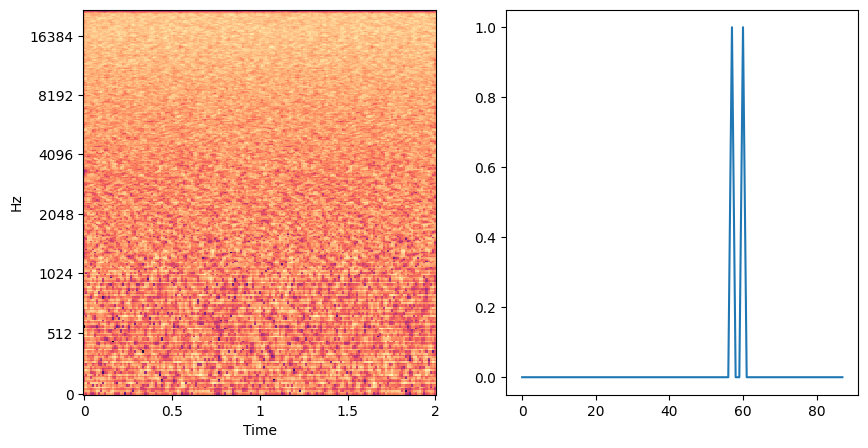

In [4]:
random_sample = random.choice(data)
sample_data = np.load(random_sample)
mel = sample_data["mel"]
label = sample_data["label"]


plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
librosa.display.specshow(mel,sr=SAMPLE_RATE, x_axis='time', y_axis='mel')

plt.subplot(1,2,2)
plt.plot(label)
plt.show()


In [5]:
train_df, eval_df = train_test_split(data,test_size = 0.3)
val_df,test_df = train_test_split(eval_df,test_size = 0.25)

print(f"train size {len(train_df)}")
print(f"validation size {len(val_df)}")
print(f"test size {len(test_df)}")

train size 26657
validation size 8568
test size 2857


In [6]:
class DataGenerator(Sequence):

    def __init__(self,audio_data,batch_size=32,shuffle=True):
        self.audio_data = audio_data
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __getitem__(self,index):
        current_batch = self.audio_data[index*self.batch_size : min((index+1)*self.batch_size, len(self.audio_data))]
        
        X,y=[],[]
        for batch_ in current_batch:
            mel_,lab_ = self.decode_data(batch_)
            X.append(mel_)
            y.append(lab_)
        return np.array(X),np.array(y)
        
        
        
    def __len__(self):
        return int(np.ceil(len(self.audio_data) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.audio_data)
        
    def decode_data(self,data_file):
        sample_array = np.load(data_file)
        mel_array = sample_array["mel"]
        label_array = sample_array["label"]
        return mel_array[..., np.newaxis], label_array
        
        

In [7]:
train_gen = DataGenerator(train_df,)
val_gen = DataGenerator(val_df)
test_gen = DataGenerator(test_df,shuffle=False)

In [8]:
mel.shape

(299, 173)

In [9]:
input_shape = train_gen[0][0].shape[1:]
input_shape

(299, 173, 1)

In [10]:
model = Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32,(5,5),activation="relu"),
    layers.MaxPooling2D((2,3),strides=2),

    layers.Conv2D(64,(3,7),activation="relu"),
    layers.MaxPooling2D((2,3),strides=2),

    layers.Conv2D(128,(1,21),activation="relu"),
    layers.MaxPooling2D((2,3),strides=2),

    layers.Flatten(),

    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(88,activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 295, 169, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 147, 84, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 78, 64)       43072     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 18, 128)       172160    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 8, 128)       0

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',      # or use 'val_AUC' for note detection
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    ),
]

In [ ]:
history = model.fit(train_gen,validation_data=val_gen,
    epochs=50,  
    callbacks=callbacks, 
    verbose=1)

Epoch 1/50
